In [70]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()
from matplotlib import pyplot as plt

from collections import defaultdict

import my_graph_helpers as mgh
import my_graph as mg
import numpy as np
import networkx as nx
import math

import itertools

In [71]:
reload(mg)
reload(mgh)

<module 'my_graph_helpers' from 'my_graph_helpers.pyc'>

In [72]:
def define_capetown_barriers(myG):
    """ based on rezero vector crezero = np.array([-31900, -3766370]) """
    be = [e for e in myG.myedges() if e.nodes[0].x < 146 and
          e.nodes[0].x > 25]
    be2 = [e for e in be if e.nodes[1].x < 146 and e.nodes[1].x > 25]

    be3 = [e for e in be2 if e.nodes[0].y < 20 and e.nodes[1].y < 20]
    todrop = [e for e in be3 if e.nodes[0].x > 25 and e.nodes[0].x < 75 and
              e.nodes[0].y > 13.4 and e.nodes[1].y > 13.4]

    for e in be3:
        if abs(e.rads) > math.pi/4:
            todrop.append(e)

    be4 = [e for e in be3 if e not in todrop]

    return be4

# Create Simple Test Graph

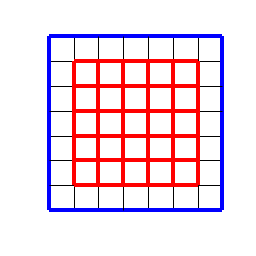

In [3]:
simpleG = mgh.testGraphLattice(8)
simpleG.name = "L0"

simpleG.plot_roads(update = True)

# Create Complicated Test Graph

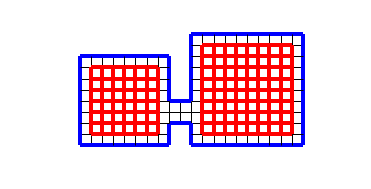

In [4]:
C1 = mgh.testGraphLattice(9)
C1.name = "Com0"
C2 = mgh.testGraphLattice(11,xshift=10,yshift=0)
C3 = mgh.testGraphLattice(3,xshift=8,yshift=2)
C4 = mg.MyGraph(nx.compose_all([C1.G, C2.G, C3.G]))

comG = C4.clean_up_geometry(0.5, connected=True)
comG.plot_roads(update=True)

# Import CapeTown Graph

In [74]:
filename = "data/CapeTown"
place = "cape"
erezero = np.array([305680, 8022350])
crezero= np.array([-31900, -3766370])
original = mgh.import_and_setup(filename, rezero=crezero, component = None,
                                threshold=1, connected=False,
                                name=place+"_S0")

data loaded


AssertionError: 

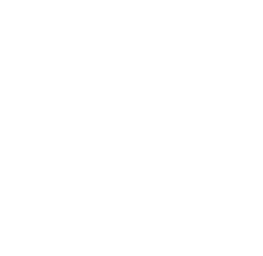

In [73]:
original.plot_roads(master = original, update = True)
cape = original.copy()

be4 = define_capetown_barriers(cape)

# mirroring efforts

[20, 70, 120, 170]


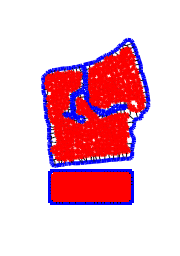

In [65]:
xshift = [50*i-30 for i in range(1,5)]
print xshift

xs = [mgh.testGraphLattice(11,xshift=x,yshift=-50,scale=5).G for x in xshift]
cm = mg.MyGraph(nx.compose_all(xs))

for n in cm.G.nodes():
    if n.x > 150:
        cm.G.remove_node(n)

cape.plot_roads()
cm.plot_roads(new_plot=False, update = True)

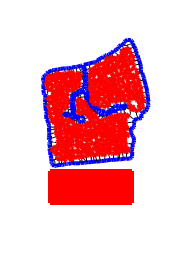

In [66]:
call = mg.MyGraph(nx.compose_all([cape.G, cm.G]))

call.plot_roads(update = True)

In [67]:
cmnodes = [n for n in cm.G.nodes() if n.y == 0]
capnodes = 

# Choose Working Graph

In [39]:
myG = simpleG.copy()
#myG = comG.copy()

myG.define_roads()
myG.define_interior_parcels()


In [34]:
nr, b = mgh.build_all_roads(myG, alpha = 16, barriers = False, wholepath=True)

Begin w 25 Interior Parcels
Cur max depth is 7, 1 parcels 
Shortest paths found for 1 parcels
18 interior parcels left
Cur max depth is 3, 18 parcels 
Shortest paths found for 18 parcels
16 interior parcels left
Cur max depth is 3, 16 parcels 
Shortest paths found for 1 parcels
15 interior parcels left
Cur max depth is 3, 15 parcels 
Shortest paths found for 0 parcels
14 interior parcels left
Cur max depth is 3, 14 parcels 
Shortest paths found for 1 parcels
12 interior parcels left
Cur max depth is 3, 12 parcels 
Shortest paths found for 0 parcels
11 interior parcels left
Cur max depth is 3, 11 parcels 
Shortest paths found for 0 parcels
9 interior parcels left
Cur max depth is 3, 9 parcels 
Shortest paths found for 0 parcels
8 interior parcels left
Cur max depth is 3, 8 parcels 
Shortest paths found for 0 parcels
7 interior parcels left
Cur max depth is 3, 7 parcels 
Shortest paths found for 0 parcels
5 interior parcels left
Cur max depth is 3, 5 parcels 
Shortest paths found for 0 p

TypeError: 'numpy.float64' object is not iterable

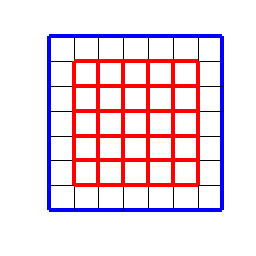

In [40]:
#remove_fake_nodes(myG)
#remove_interior_fake(myG)



myG.plot_roads()

In [41]:
result, depth = mgh.form_equivalence_classes(myG)

In [42]:
result

{1: [Face with centroid at (2.50,6.50),
  Face with centroid at (0.50,3.50),
  Face with centroid at (6.50,4.50),
  Face with centroid at (4.50,0.50),
  Face with centroid at (0.50,2.50),
  Face with centroid at (3.50,2.50),
  Face with centroid at (1.50,4.50),
  Face with centroid at (1.50,1.50),
  Face with centroid at (6.50,1.50),
  Face with centroid at (1.50,6.50),
  Face with centroid at (6.50,6.50),
  Face with centroid at (5.50,1.50),
  Face with centroid at (3.50,6.50),
  Face with centroid at (4.50,6.50),
  Face with centroid at (2.50,5.50),
  Face with centroid at (6.50,5.50),
  Face with centroid at (3.50,4.50),
  Face with centroid at (5.50,5.50),
  Face with centroid at (4.50,5.50),
  Face with centroid at (6.50,2.50),
  Face with centroid at (6.50,3.50),
  Face with centroid at (3.50,3.50),
  Face with centroid at (2.50,4.50),
  Face with centroid at (5.50,0.50),
  Face with centroid at (3.50,5.50),
  Face with centroid at (0.50,0.50),
  Face with centroid at (5.50,6.50)

In [43]:
r5 = result[5]
r7 =result[7]

In [45]:
len(r5)

9

In [47]:
len(set(r5) - set(r7))


8

In [48]:
set(r5)-set([])

{Face with centroid at (4.50,4.50),
 Face with centroid at (4.50,2.50),
 Face with centroid at (2.50,2.50),
 Face with centroid at (3.50,2.50),
 Face with centroid at (3.50,4.50),
 Face with centroid at (3.50,3.50),
 Face with centroid at (2.50,3.50),
 Face with centroid at (2.50,4.50),
 Face with centroid at (4.50,3.50)}

In [51]:
result.get(11,[])

[]

In [26]:
import math
def remove_interior_fake(myG):
    for n in myG.G.nodes():
        if math.floor(n.y) != n.y:
            myG.G.remove_node(n)
            print "node_dropped"


In [18]:
def remove_fake_nodes(myG):
    for n in myG.G.nodes():
        if n.y> 1000:
            myG.G.remove_node(n)
            print "node_dropped"
    